In [12]:
#data preprocessing
import pandas as pd
#math operations
import numpy as np
#machine learning
from catboost import CatBoostRegressor, Pool
#data scaling
from sklearn.preprocessing import StandardScaler
#hyperparameter optimization
from sklearn.model_selection import GridSearchCV
#support vector machine model
from sklearn.svm import NuSVR, SVR
#kernel ridge model
from sklearn.kernel_ridge import KernelRidge
#data visualization
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error
import seaborn as sns

In [6]:
# Step 1 - Feature Engineering and signifiance of these statistical features
import scipy.stats as stats

def gen_features(X):
    strain = []
    strain.append(X.mean())
    strain.append(X.std())
    strain.append(X.min())
    strain.append(X.max())
    strain.append(X.kurtosis())
    strain.append(X.skew())    
    strain.append(np.quantile(X,0.01))
    strain.append(np.quantile(X,0.05))
    strain.append(np.quantile(X,0.95))
    strain.append(np.quantile(X,0.99))
    strain.append(np.abs(X).max())
    strain.append(np.abs(X).mean())
    strain.append(np.abs(X).std())
    #mystuff
    strain.append(np.var(X))
    strain.append(stats.sem(X))
    strain.append(stats.variation(X))
    return pd.Series(strain)

In [8]:
#Create features DF
train = pd.read_csv('train.csv', iterator=True, chunksize=150_000, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})

features_X = pd.DataFrame()
times_y = pd.Series()
for df in train:
    ch = gen_features(df['acoustic_data'])
    features_X =features_X.append(ch, ignore_index=True)
    times_y =times_y.append(pd.Series(df['time_to_failure'].values[-1]))

In [9]:
#Split data to training and test
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(features_X,  times_y, test_size=0.10, random_state=72)

In [10]:
#Model #1 - Catboost

train_pool = Pool(train_X, train_y)
cat_model = CatBoostRegressor(iterations=10000, loss_function='MAE', boosting_type='Ordered')
cat_model.fit(train_X, train_y, silent=True)

cat_test_predictions = cat_model.predict(test_X)
cat_train_predictions = cat_model.predict(train_X)

score = mean_absolute_error(test_y, cat_test_predictions)
print("Cat Boost MAE on Test: " + str(score))

score = mean_absolute_error(train_y, cat_train_predictions)
print("Cat Boost MAE on Train: " + str(score))

Cat Boost MAE on Test: 2.127640998824054
Cat Boost MAE on Train: 1.7455322367765607


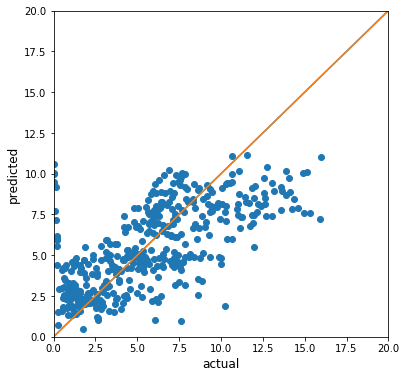

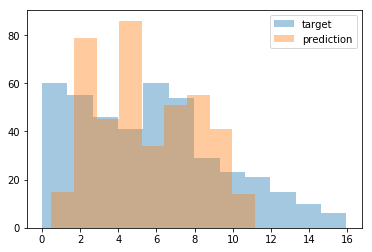

In [14]:
# Predictions vs actual values
plt.figure(figsize=(6, 6))
plt.scatter(test_y, cat_test_predictions)
plt.xlim(0, 20)
plt.ylim(0, 20)
plt.xlabel('actual', fontsize=12)
plt.ylabel('predicted', fontsize=12)
plt.plot([(0, 0), (20, 20)], [(0, 0), (20, 20)])
plt.show()


# Hist plot
sns.distplot(test_y, kde=False, label='target');
sns.distplot(cat_test_predictions, kde=False, label='prediction');
plt.legend();

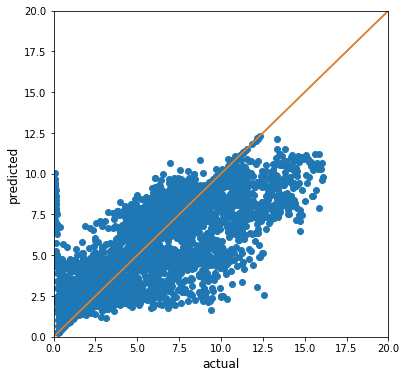

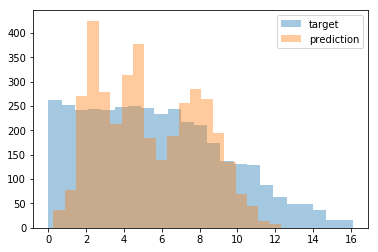

In [15]:
# Predictions vs actual values
plt.figure(figsize=(6, 6))
plt.scatter(train_y, cat_train_predictions)
plt.xlim(0, 20)
plt.ylim(0, 20)
plt.xlabel('actual', fontsize=12)
plt.ylabel('predicted', fontsize=12)
plt.plot([(0, 0), (20, 20)], [(0, 0), (20, 20)])
plt.show()


# Hist plot
sns.distplot(train_y, kde=False, label='target');
sns.distplot(cat_train_predictions, kde=False, label='prediction');
plt.legend();

In [16]:
#Model #2 - Support Vector Machine w/ RBF + Grid Search

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import NuSVR, SVR


scaler = StandardScaler()
scaler.fit(train_X)
X_train_scaled = scaler.transform(train_X)

parameters = [{'gamma': [0.001, 0.005, 0.01, 0.02, 0.05, 0.1],
               'C': [0.1, 0.2, 0.25, 0.5, 1, 1.5, 2]}]
               #'nu': [0.75, 0.8, 0.85, 0.9, 0.95, 0.97]}]

SVM_model = GridSearchCV(SVR(kernel='rbf', tol=0.01), parameters, cv=5, scoring='neg_mean_absolute_error')
SVM_model.fit(X_train_scaled, train_y.values.flatten())

X_test_scaled = scaler.transform(test_X)

SVM_predictions = SVM_model.predict(X_test_scaled)
SVM_train_predictions = SVM_model.predict(X_train_scaled)

score = mean_absolute_error(test_y, SVM_predictions)
print("SVM model Test MAE: " + str(score))

score = mean_absolute_error(train_y, SVM_train_predictions)
print("SVM model Train MAE: " + str(score))

SVM model Test MAE: 2.117549823760987
SVM model Train MAE: 2.033954637974877


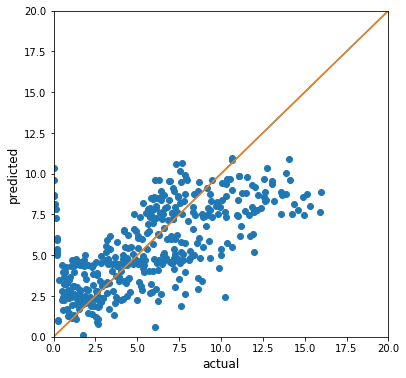

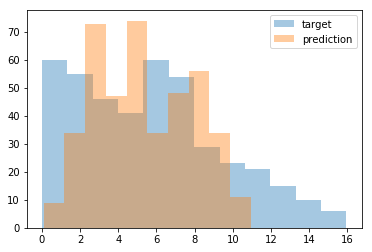

In [17]:
# Predictions vs actual values
plt.figure(figsize=(6, 6))
plt.scatter(test_y, SVM_predictions)
plt.xlim(0, 20)
plt.ylim(0, 20)
plt.xlabel('actual', fontsize=12)
plt.ylabel('predicted', fontsize=12)
plt.plot([(0, 0), (20, 20)], [(0, 0), (20, 20)])
plt.show()


# Hist plot
sns.distplot(test_y, kde=False, label='target');
sns.distplot(SVM_predictions, kde=False, label='prediction');
plt.legend();

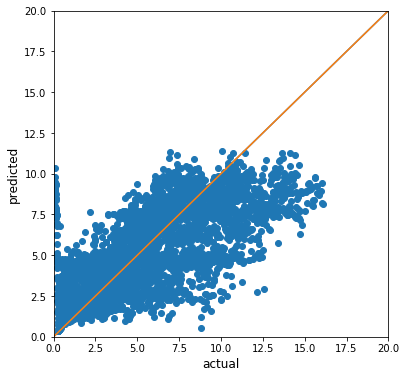

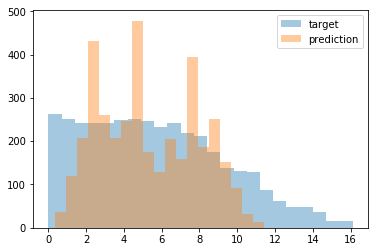

In [18]:
# Predictions vs actual values
plt.figure(figsize=(6, 6))
plt.scatter(train_y, SVM_train_predictions)
plt.xlim(0, 20)
plt.ylim(0, 20)
plt.xlabel('actual', fontsize=12)
plt.ylabel('predicted', fontsize=12)
plt.plot([(0, 0), (20, 20)], [(0, 0), (20, 20)])
plt.show()


# Hist plot
sns.distplot(train_y, kde=False, label='target');
sns.distplot(SVM_train_predictions, kde=False, label='prediction');
plt.legend();

In [63]:
#Model 3 Random Forest Regressor

from sklearn.ensemble import RandomForestRegressor

test_score = 10
rounds = 1

RF_Model = RandomForestRegressor(n_estimators=50, min_samples_split = 2, min_samples_leaf=2, max_features= .58, 
                                     bootstrap = False, n_jobs=-1, oob_score=False)
while(test_score > 2.22):
    RF_Model.fit(train_X,train_y)

    RF_predictions = RF_Model.predict(test_X)

    test_score = mean_absolute_error(test_y, RF_predictions)
    
    print("Round: " + str(rounds) + " Score: " + str(test_score))
    rounds += 1

print("RF model Test MAE: " + str(test_score))

RF_train_predictions = RF_Model.predict(train_X)

score = mean_absolute_error(train_y, RF_train_predictions)

print("RF model Train MAE: " + str(score))

Round: 1 Score: 2.254060167154231
Round: 2 Score: 2.2299585983228374
Round: 3 Score: 2.274216224889986
Round: 4 Score: 2.244138894739064
Round: 5 Score: 2.2384992202181193
Round: 6 Score: 2.280681337852821
Round: 7 Score: 2.2550266599216973
Round: 8 Score: 2.2434831894651484
Round: 9 Score: 2.2505104636554263
Round: 10 Score: 2.255094292650752
Round: 11 Score: 2.2387653875295
Round: 12 Score: 2.2490462392331008
Round: 13 Score: 2.2352770247828526
Round: 14 Score: 2.2433372498328663
Round: 15 Score: 2.2401978527699793
Round: 16 Score: 2.2537638629281704
Round: 17 Score: 2.2394577682605776
Round: 18 Score: 2.26393356150641
Round: 19 Score: 2.2290133068019102
Round: 20 Score: 2.2561916995760596
Round: 21 Score: 2.2491144281665387
Round: 22 Score: 2.2640766497390317
Round: 23 Score: 2.25418953926038
Round: 24 Score: 2.23008134240243
Round: 25 Score: 2.241866952038913
Round: 26 Score: 2.2727468347819566
Round: 27 Score: 2.265326906853466
Round: 28 Score: 2.26247655737212
Round: 29 Score: 2.

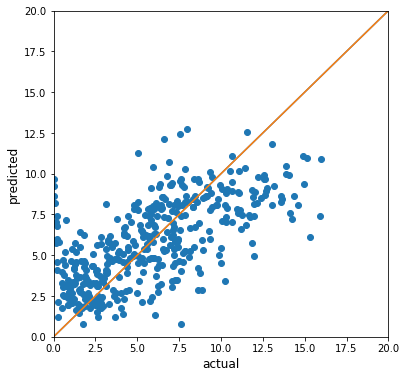

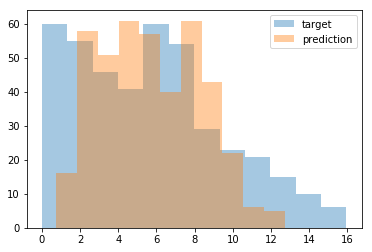

In [64]:
# Predictions vs actual values
plt.figure(figsize=(6, 6))
plt.scatter(test_y, RF_predictions)
plt.xlim(0, 20)
plt.ylim(0, 20)
plt.xlabel('actual', fontsize=12)
plt.ylabel('predicted', fontsize=12)
plt.plot([(0, 0), (20, 20)], [(0, 0), (20, 20)])
plt.show()


# Hist plot
sns.distplot(test_y, kde=False, label='target');
sns.distplot(RF_predictions, kde=False, label='prediction');
plt.legend();

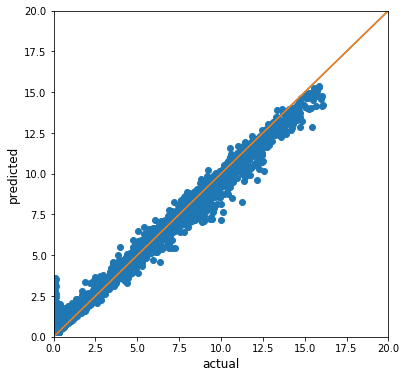

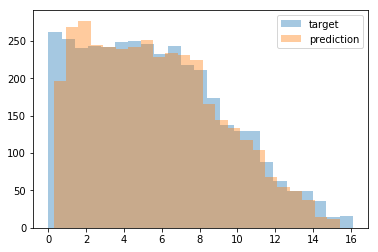

In [65]:
# Predictions vs actual values
plt.figure(figsize=(6, 6))
plt.scatter(train_y, RF_train_predictions)
plt.xlim(0, 20)
plt.ylim(0, 20)
plt.xlabel('actual', fontsize=12)
plt.ylabel('predicted', fontsize=12)
plt.plot([(0, 0), (20, 20)], [(0, 0), (20, 20)])
plt.show()


# Hist plot
sns.distplot(train_y, kde=False, label='target');
sns.distplot(RF_train_predictions, kde=False, label='prediction');
plt.legend();

In [58]:
#Save Kaggle Predictions all at once
import glob

file_names = sorted(list(glob.glob("./test/*.csv")))

output = ["seg_id,time_to_failure\n","seg_id,time_to_failure\n","seg_id,time_to_failure\n"]

for file_name in file_names:
    test = pd.read_csv(file_name, dtype={'acoustic_data': np.int16})
    ch = gen_features(test['acoustic_data'])
    X_test = pd.DataFrame(ch).transpose()
    
    #Cat Prediction
    prediction = cat_model.predict(X_test)
    output[0] += file_name.split(".")[1][6:] + "," + str(prediction[0]) + "\n"
    
    #SVM Prediction
    X_test_scaled = scaler.transform(X_test)
    prediction = SVM_model.predict(X_test_scaled)
    output[1] += file_name.split(".")[1][6:] + "," + str(prediction[0]) + "\n"
    
    #Random Forest Prediction
    prediction = RF_Model.predict(X_test)
    output[2] += file_name.split(".")[1][6:] + "," + str(prediction[0]) + "\n"

    
output_file = open("test_results_Cat_Model.csv", "w+")
output_file.write(output[0])
output_file.close()

output_file = open("test_results_SVM_Model.csv", "w+")
output_file.write(output[1])
output_file.close()

output_file = open("test_results_RF_Model.csv", "w+")
output_file.write(output[2])
output_file.close()